# Borehole rock-physics
## Investigating the accuracy of various rock-physics transforms using borehole data

In [446]:
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd

In [2]:
def join_las(fname_base_las,fname_added_las,depthname='DEPT',freq=.5,exportname='export',writeyn=False):
    import lasio
    def check_type(las):
        if isinstance(las,Path) or isinstance(las,str):
            return lasio.read(Path(las).as_posix())
        else:
            return las

    baselas = check_type(fname_base_las)
    addlas = check_type(fname_added_las)
    
    #Line up the depths
    adddept = addlas[depthname]
    basedept = baselas[depthname]
    
    if freq!=.5:
        raise Exception('Currently only supported for half foot')
    
    add_dept_halffoot = adddept[addlas[depthname]%0.5==0]
    adddept2basedept = [np.where(ind==basedept)[0] for ind in list(add_dept_halffoot)]
    adddept2basedept = np.r_[[np.asscalar(ind) if len(ind)==1 else np.nan for ind in adddept2basedept]]
    mask = ~np.isnan(adddept2basedept)

    #Mask out nan values
    adddept2basedeptma = adddept2basedept[mask].astype('int32')
    
    for i,nam in enumerate(addlas.keys()):
        if nam==depthname:
            continue
        add_halffoot = addlas[nam][addlas[depthname]%0.5==0]
        add_halffootma = add_halffoot[mask]

        #Create data vector for bas las
        base_data_new = np.ones(len(basedept))*-999.25
        base_data_new[base_data_new==-999.25]  = np.nan
        base_data_new[adddept2basedeptma] = add_halffootma
        
        #Add the curve 
        baselas.add_curve(nam, base_data_new, unit=addlas.curves[i].unit)
    
    if writeyn:
        #export combined las object to .las + .csv files
        baselas.to_csv(Path(exportname).as_posix() + '.csv')
        baselas.write(Path(exportname).as_posix() + '.las')
    return baselas

In [3]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')

mw8_fres_fname = 'mw8_fres.las'
mw8_tmp_fname = 'mw8_tmp.las'
mw8_all_fname = 'MW-8D.las'


###  Convert all to feet from meters

In [4]:
import glob
from scipy.stats import mode
def myround(x, base=.5):
    return base*np.round(x/base)

f_MWm = glob.glob(lasdir.joinpath('MW-[1-9]Dm.las').as_posix())
for f in f_MWm:
    lasobj = lasio.read(f)
    lasexpt = lasio.LASFile()
    
    for c in lasobj.curves:
        if c.mnemonic=='DEPT':
            continue
        lasexpt.insert_curve_item(0,c)
    #make sure DEPT is the first curve for aesthetics
    d = lasobj.get_curve('DEPT')
    d_mode = mode(np.diff(np.round(d.data/.3048,decimals=2))).mode[0]
    if d_mode==0.5:
        lasexpt.insert_curve(0,'DEPT',myround(d.data/.3048,base=.5),unit='F')
        lasexpt.write(f[:-5]+'f.las')
    else:
        raise Exception('Needs to be .5 feet')

###  Combine base las files with the digitized FRES and TMP las files

In [5]:
MWnos = [1,4,5,6,7,8,9]
for i in range(len(MWnos)):
    f_base = glob.glob(lasdir.joinpath('MW-'+str(MWnos[i])+'Df.las').as_posix())[0]
    f_tmp =  glob.glob(lasdir.joinpath('mw'+str(MWnos[i])+'*.las').as_posix())
   #join tmp and fres if they're 2 separate files
    if len(f_tmp)==0:
        continue
    elif len(f_tmp)==1:
        las_tmp = lasio.read(f_tmp[0])
    elif len(f_tmp)==2:
        las_tmp = join_las(f_tmp[0],f_tmp[1],exportname=f_tmp[0]+'_joined',writeyn=False)
    #export all as .las and .csv
    las_out = join_las(f_base,las_tmp,exportname=f_base[:-5] + '_all',writeyn=True)

In [44]:
f_MWall = glob.glob(lasdir.joinpath('MW-[1-9]D_all.las').as_posix())
f_MWall = sorted(f_MWall,key=os.path.basename)
MWnames = [Path(f).stem[:-4] for f in f_MWall]
print(MWnames)

['MW-1D', 'MW-4D', 'MW-5D', 'MW-6D', 'MW-7D', 'MW-8D', 'MW-9D']


### Import lithology, screen, and TDS data


In [537]:
def m2ft(df,colname,newcolname=None):
    if newcolname is None:
        newcolname = colname + 'ft'
    df[newcolname] = df[colname]/.3048
    return

mwlith= pd.read_excel(auxdir.joinpath('Lith_MPWSP.xlsx'))
mwtds= pd.read_excel(auxdir.joinpath('TDS_Baseline_MPWSP.xlsx'),index_col=0)
mwscreen = pd.read_excel(auxdir.joinpath('MPWSP_Screen.xlsx'),index_col=0)
wellids = np.unique(mwlith['WellID'])

m2ft(mwlith,'Top_m','topft')
m2ft(mwlith,'Bottom_m','botft')
m2ft(mwscreen,'Screen_Top','topft')
m2ft(mwscreen,'Screen_Bottom','botft')

In [220]:
#Create list of DataFrames
frames = []
for f in f_MWall:
    las = lasio.read(f)
    #Convert to DF and mask for plots
    df_temp = las.df()
#     df_temp = df_temp.loc[~np.logical_or(np.isnan(df_temp['FRES']),df_temp['FRES']==-999.25)]
    frames.append(df_temp)

In [227]:
# Assign lith to each DataFrame
for i,frame in enumerate(frames):
    nam = MWnames[i]
    welmask = mwlith['WellID']==nam
    df_lith = []
    for d in frame.index:
        v=mwlith[welmask][((d>=mwlith[welmask]['topft']) & (d<mwlith[welmask]['botft']))]['Lith_Code_Orig']
        if len(v)==1:
            df_lith.append(v.values[0])
        elif len(v)>1:
            print(v)
            raise Exception('multiple values in this interval ??')
        else:
            df_lith.append(np.nan)
    frames[i] = frame.assign(lith=df_lith)

### Join all Dataframes together and save

In [225]:
df = pd.concat(frames, keys=MWnames, sort=False)
df.to_pickle(lasdir.joinpath('allMWs'))

### Create common masks

In [472]:
def mask_nonan(df,nan_col_list):
    mask = ~df.isnull()
    return mask.loc[:,nan_col_list].all(axis=1)

def mask_noclay(df,nan_col_list):
    return ~df.loc[mask_nonan(df,nan_col_list),'lith'].str.contains("C")

def mask_SP_only(df,nan_col_list):
    return df.loc[mask_nonan(df,nan_col_list),'lith']=="SP"

def mask_stds(df,nstds,testcol,nan_col_list):
    pop = df.loc[mask_nonan(df,nan_col_list),testcol]
    return  np.logical_and(pop < np.mean(pop)+nstds*np.std(pop),
                           pop > np.mean(pop)-nstds*np.std(pop))


# mask_noclay = np.logical_or(df.loc[:,'lith'].str.contains("C"),df.loc[:,'lith'].isna())
nan_cols = ['FRES','lith','RILD']

###  Archie's  Law
$$R_o = F*R_w $$
$$R_o = \phi^{-m}*R_w $$
### Arp's Law in degrees Fahrenheit
$$R_{w2} = R_{w1}\frac{T_1 + 6.77}{T_2 + 6.77}$$

In [424]:
ref_temp= 77
fresc = df.loc[:,'FRES']*(df.loc[:,'TMP']+6.77)/(ref_temp + 6.77)
df=df.assign(FRESc = fresc);

Text(0.5,1,'Original vs Corrected Fluid Resistivity')

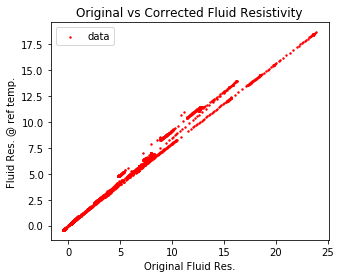

In [425]:
plt.scatter(df.loc[:,'FRES'],df.loc[:,'FRESc'],label='data',c='red',s=2,marker='o')
# plt.plot(np.arange(df['FRES'].min(),df['FRES'].max()),np.arange(df['FRES'].min(),df['FRES'].max()),'k',label='one-to-one')
plt.legend()
plt.gca().set_aspect(1)
plt.xlabel('Original Fluid Res.')
plt.ylabel('Fluid Res. @ ref temp.')
plt.title('Original vs Corrected Fluid Resistivity')

### Bulk Resistivity vs. Fluid Resistivity

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


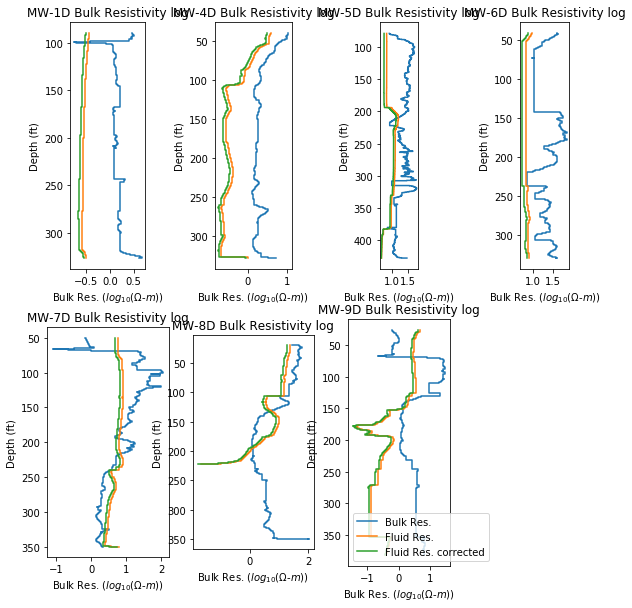

In [473]:
df_plot = df.loc[mask_nonan(df,nan_cols),:]
mask = mask_noclay(df_plot,nan_cols)

f,axs=plt.subplots(2,4,figsize=(10,10))
for i,ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i == axs.size-1:
        plt.axis('off')
        continue
    nam = MWnames[i]
    ax.invert_yaxis()
    plt.step(np.log10(df_plot[mask].loc[nam].loc[:,'RILD']),df_plot[mask].loc[nam].index,label='Bulk Res.')
    plt.step(np.log10(df_plot[mask].loc[nam].loc[:,'FRES']),df_plot[mask].loc[nam].index,label='Fluid Res.')
    plt.step(np.log10(df_plot[mask].loc[nam].loc[:,'FRESc']),df_plot[mask].loc[nam].index,label='Fluid Res. corrected')
    plt.ylabel('Depth (ft)')
    plt.xlabel('Bulk Res. ($log_{10}(\Omega$-$m$))');
    ax.set_aspect(1/50)
    plt.title(nam + ' Bulk Resistivity log');
    if i== axs.size-2:
        ax.legend();

In [474]:
from scipy import stats
def x_y_regression(xin,yin,cin,msk=None,slpname='F'):
    if msk is None:
        x=xin
        y=yin
        c=cin
    else:
        x=xin[msk]
        y=yin[msk]
        c=cin[msk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    plt.set_cmap('viridis_r')
    f,ax = plt.subplots(1,figsize=(7,4))
    plt.scatter(x,y,c=c)
    plt.plot(x,slope*x + intercept,'--k')
    plt.text(x.mean(),y.mean()*2,'{} = {:.2f} \n$R^2$ = {:.2f}'.format(slpname,slope,r_value**2))
    cb = plt.colorbar()
    cb.set_label('Depth (ft)', rotation=0)
    return f,ax

### Applying Archie's Law

<Figure size 432x288 with 0 Axes>

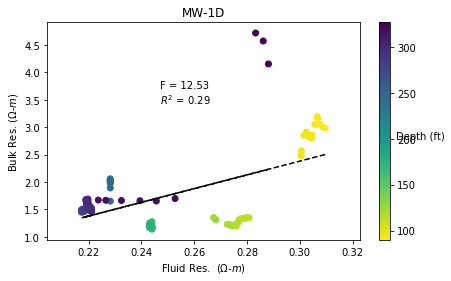

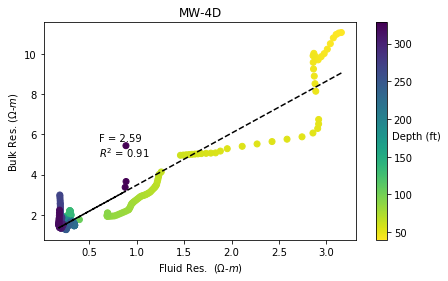

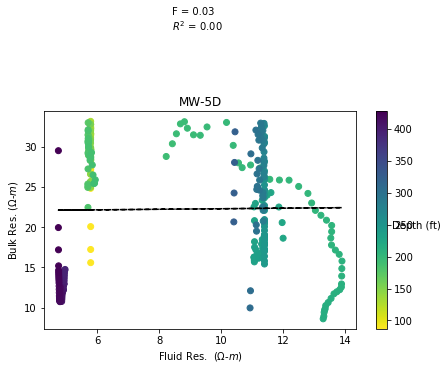

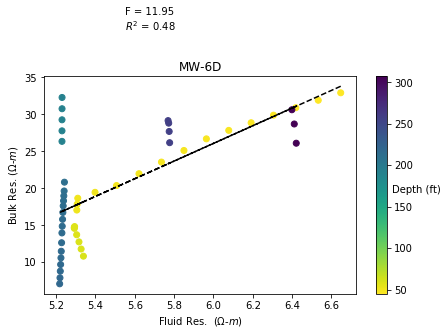

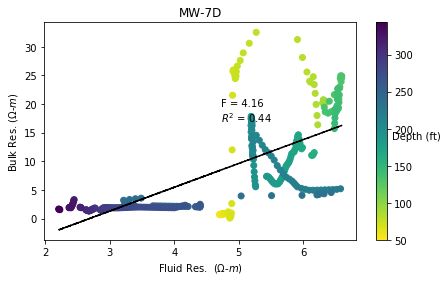

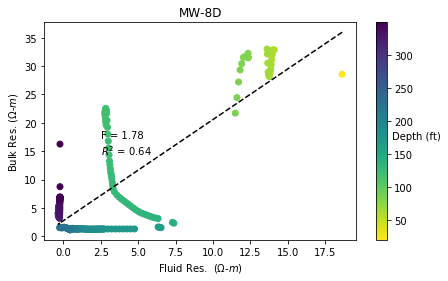

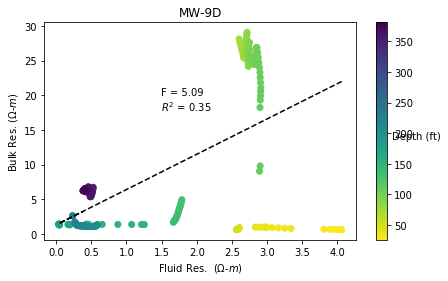

In [492]:
df_plot = df.loc[mask_nonan(df,nan_cols),:]
df_plot = df_plot.loc[mask_SP_only(df_plot,nan_cols),:]
mask = mask_stds(df_plot,1,'RILD',nan_cols)

for i,nam in enumerate(MWnames):
    x = df_plot[mask].loc[nam].loc[:,'FRESc']
    y = df_plot[mask].loc[nam].loc[:,'RILD']
    c = df_plot[mask].loc[nam].index
    f,ax = x_y_regression(x,y,c);
    ax.set_title(nam)
    plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
    plt.ylabel('Bulk Res. ($\Omega$-$m$)')


<Figure size 432x288 with 0 Axes>

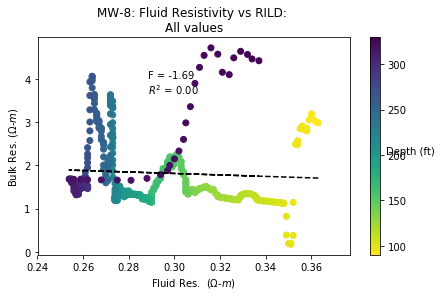

<Figure size 432x288 with 0 Axes>

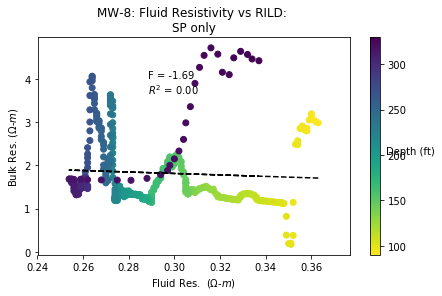

In [91]:
x = df['FRES']
y = df['RILD']
c = df.index
f,ax = x_y_regression(x,y,c);
plt.title('MW-8: Fluid Resistivity vs RILD: \nAll values')
plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
plt.ylabel('Bulk Res. ($\Omega$-$m$)')
plt.show();

f,ax = x_y_regression(x,y,c);
plt.title('MW-8: Fluid Resistivity vs RILD: \nSP only')
plt.show();